## Import all the libraries

In [2]:
import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from dask.diagnostics import ProgressBar
from datetime import date
import json
import os
import warnings
import seawater
import re

warnings.filterwarnings('ignore')


## Parameters

In [3]:
ymin=2010;mmin=1;dmin=1
ymax=2010;mmax=9;dmax=30
# depth of the desired comparison profile in m
depthmin=1000
# radius of the circle around the profile location in which we take the modeled profiles, in °  
radius_max=0.25
# period of time around the profile sampling date in which we take the modeled profiles, in days
period=5
# minimum amount of model profiles to be considered to make a significant statistical comparison, for instance in a 1° square and 30-days window we have 2.6 millions modeled profiles, in a 0.5°x10 days 216 000
number_of_model_profiles=100000
# 
debug_plot=False


In [4]:
datemin=datetime.date(ymin,mmin,dmin)
datemax=datetime.date(ymax,mmax,dmax)
jsonfile='txt/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.json'

## Read the jsonfile

In [5]:
sourcefile=open(jsonfile,'rU')
infos=json.load(sourcefile)
nb_profilesEN4=len(infos)


In [6]:
    prof=0
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)


Processing profile  Profile_20100106_prof.nc_71


In [7]:
    # Open the netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'


In [8]:
print(outname)

/gpfswork/rech/egi/rote001/EN4/profiles_files/MEDWEST60-BLBT02/Profile_20100106_prof_71_MEDWEST60-BLBT02_TS.nc


In [10]:
dsprof=xr.open_dataset(outname)

depth_en4=dsprof['depth_en4']
temp_en4=dsprof['temp_profileEN4']
salt_en4=dsprof['salt_profileEN4']
mean_temp_model=dsprof['mean_temp_model']
mean_salt_model=dsprof['mean_salt_model']
percent10_temp_model=dsprof['percent10_temp_model']
percent10_salt_model=dsprof['percent10_salt_model']
percent90_temp_model=dsprof['percent90_temp_model']
percent90_salt_model=dsprof['percent90_salt_model']
obs_lat=dsprof['latitude_profileEN4']
obs_lon=dsprof['longitude_profileEN4']
obs_time=dsprof['time_profileEN4']


In [11]:
print(depth_en4)

<xarray.DataArray 'depth_en4' (depth: 111)>
array([   7.938258,   13.89175 ,   18.852859,   23.81385 ,   28.774719,
         32.743328,   37.703976,   43.656609,   48.616997,   53.577267,
         57.545399,   63.49744 ,   69.449318,   72.425186,   77.38488 ,
         82.344444,   87.303909,   92.263237,   97.22245 ,  102.181541,
        107.140495,  112.099373,  117.058098,  123.008415,  126.975189,
        132.925232,  136.891815,  141.849945,  147.799561,  152.757431,
        157.715179,  162.672791,  166.638824,  171.596222,  176.553528,
        181.510696,  187.459152,  192.416077,  197.372849,  212.242493,
        237.022873,  261.800262,  286.574646,  310.355286,  335.12381 ,
        359.889374,  384.651978,  409.411591,  434.168182,  459.911957,
        484.662567,  508.420349,  533.1651  ,  557.90686 ,  582.645752,
        607.381653,  632.114563,  656.844604,  681.571594,  706.295654,
        731.016785,  755.734924,  781.438782,  805.162598,  829.871887,
        854.57843 , 

In [13]:
# Project the profile to standart vertical levels
vert_standart=[0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,
               110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,
               420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,
               820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,
               1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]

temp_en4_standart=np.interp(vert_standart,depth_en4,temp_en4)
salt_en4_standart=np.interp(vert_standart,depth_en4,salt_en4)
mean_temp_model_standart=np.interp(vert_standart,depth_en4,mean_temp_model)
mean_salt_model_standart=np.interp(vert_standart,depth_en4,mean_salt_model)
percent10_temp_model_standart=np.interp(vert_standart,depth_en4,percent10_temp_model)
percent10_salt_model_standart=np.interp(vert_standart,depth_en4,percent10_salt_model)
percent90_temp_model_standart=np.interp(vert_standart,depth_en4,percent90_temp_model)
percent90_salt_model_standart=np.interp(vert_standart,depth_en4,percent90_salt_model)


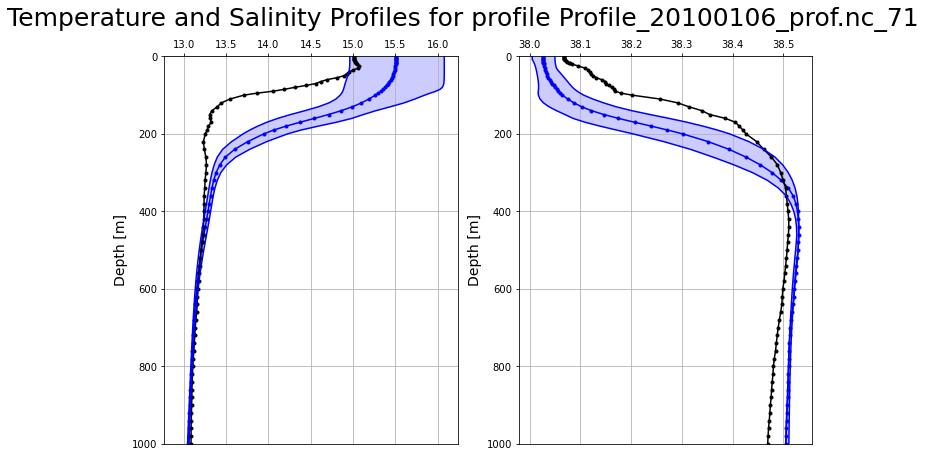

In [15]:
        fig, axs = plt.subplots(1,2, figsize=(10, 6))
        axs = axs.ravel()
        title = 'Temperature and Salinity Profiles for profile '+reference
        plt.suptitle(title,size = 25,y=1.05)
        axs[0].plot(mean_temp_model_standart,vert_standart,'b.-', label='temp model')
        axs[0].plot(temp_en4_standart,vert_standart,'k.-', label='temp en4')
        axs[0].set_ylabel('Depth [m]', size=14)
        axs[0].set_ylim(depthmin, 0)
        axs[0].grid(True, which='both')
        axs[0].xaxis.tick_top()
        axs[0].xaxis.set_label_position('top') 
        axs[0].plot(percent10_temp_model_standart,vert_standart,'b-', label='percent10')
        axs[0].plot(percent90_temp_model_standart,vert_standart,'b-', label='percent90')
        axs[0].fill_betweenx(vert_standart, percent10_temp_model_standart, x2=percent90_temp_model_standart, alpha=0.2, facecolor='b')

        axs[1].plot(mean_salt_model_standart,vert_standart,'b.-', label='salt model')
        axs[1].plot(salt_en4_standart,vert_standart,'k.-', label='salt en4')
        axs[1].set_ylabel('Depth [m]', size=14)
        axs[1].set_ylim(depthmin, 0)
        axs[1].grid(True, which='both')
        axs[1].xaxis.tick_top()
        axs[1].xaxis.set_label_position('top') 
        axs[1].plot(percent10_salt_model_standart,vert_standart,'b-', label='percent10')
        axs[1].plot(percent90_salt_model_standart,vert_standart,'b-', label='percent90')
        axs[1].fill_betweenx(vert_standart, percent10_salt_model_standart, x2=percent90_salt_model_standart, alpha=0.2, facecolor='b')
        fig.tight_layout()
        plt.savefig('plots/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'_prof'+str(prof)+'.png')


In [16]:
    all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))


In [17]:
for prof in np.arange(nb_profilesEN4):
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)
    # Open the netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    dsprof=xr.open_dataset(outname)

    depth_en4=dsprof['depth_en4']
    temp_en4=dsprof['temp_profileEN4']
    salt_en4=dsprof['salt_profileEN4']
    mean_temp_model=dsprof['mean_temp_model']
    mean_salt_model=dsprof['mean_salt_model']
    percent10_temp_model=dsprof['percent10_temp_model']
    percent10_salt_model=dsprof['percent10_salt_model']
    percent90_temp_model=dsprof['percent90_temp_model']
    percent90_salt_model=dsprof['percent90_salt_model']
    obs_lat=dsprof['latitude_profileEN4']
    obs_lon=dsprof['longitude_profileEN4']
    obs_time=dsprof['time_profileEN4']
    # Project the profile to standart vertical levels
    vert_standart=[0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,
                   110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,
                   420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,
                   820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,
                   1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]

    temp_en4_standart=np.interp(vert_standart,depth_en4,temp_en4)
    salt_en4_standart=np.interp(vert_standart,depth_en4,salt_en4)
    mean_temp_model_standart=np.interp(vert_standart,depth_en4,mean_temp_model)
    mean_salt_model_standart=np.interp(vert_standart,depth_en4,mean_salt_model)
    percent10_temp_model_standart=np.interp(vert_standart,depth_en4,percent10_temp_model)
    percent10_salt_model_standart=np.interp(vert_standart,depth_en4,percent10_salt_model)
    percent90_temp_model_standart=np.interp(vert_standart,depth_en4,percent90_temp_model)
    percent90_salt_model_standart=np.interp(vert_standart,depth_en4,percent90_salt_model)

    #Fill the all profiles
    all_temp_mean_model[prof,:]=mean_temp_model_standart[:]
    all_salt_mean_model[prof,:]=mean_salt_model_standart[:]
    all_temp_en4[prof,:]=temp_en4_standart[:]
    all_salt_en4[prof,:]=salt_en4_standart[:]
    all_temp_percent10_model[prof,:]=percent10_temp_model_standart[:]
    all_salt_percent10_model[prof,:]=percent10_salt_model_standart[:]
    all_temp_percent90_model[prof,:]=percent90_temp_model_standart[:]
    all_salt_percent90_model[prof,:]=percent90_salt_model_standart[:]


Processing profile  Profile_20100106_prof.nc_71
Processing profile  Profile_20100106_prof.nc_76
Processing profile  Profile_20100108_prof.nc_90
Processing profile  Profile_20100108_prof.nc_92
Processing profile  Profile_20100109_prof.nc_0
Processing profile  Profile_20100110_prof.nc_0
Processing profile  Profile_20100113_prof.nc_69
Processing profile  Profile_20100115_prof.nc_0
Processing profile  Profile_20100116_prof.nc_79
Processing profile  Profile_20100118_prof.nc_85
Processing profile  Profile_20100118_prof.nc_88
Processing profile  Profile_20100119_prof.nc_1
Processing profile  Profile_20100120_prof.nc_0
Processing profile  Profile_20100123_prof.nc_72
Processing profile  Profile_20100125_prof.nc_1
Processing profile  Profile_20100126_prof.nc_69
Processing profile  Profile_20100128_prof.nc_92
Processing profile  Profile_20100128_prof.nc_94
Processing profile  Profile_20100129_prof.nc_0
Processing profile  Profile_20100131_prof.nc_83
Processing profile  Profile_20100202_prof.nc_70

FileNotFoundError: [Errno 2] No such file or directory: b'/gpfswork/rech/egi/rote001/EN4/profiles_files/MEDWEST60-BLBT02/Profile_20100416_prof_74_MEDWEST60-BLBT02_TS.nc'

In [20]:
all_salt_percent90_model[0]

array([38.05000106, 38.05000106, 38.05000106, 38.05000106, 38.05000492,
       38.05013019, 38.05025546, 38.05038413, 38.05057227, 38.0507604 ,
       38.05101108, 38.05179679, 38.05298728, 38.05542189, 38.058581  ,
       38.06197196, 38.06528186, 38.06848498, 38.0716131 , 38.07477154,
       38.07799194, 38.08116701, 38.08468823, 38.08896346, 38.09406351,
       38.09994806, 38.10668426, 38.12451218, 38.14603213, 38.17042906,
       38.20100071, 38.23706922, 38.27491873, 38.3103412 , 38.34171396,
       38.36973933, 38.3942907 , 38.43209866, 38.46149997, 38.48356343,
       38.49867313, 38.50973746, 38.51757436, 38.52309821, 38.52671066,
       38.52862407, 38.52963468, 38.53023522, 38.53056668, 38.5305363 ,
       38.52988451, 38.52894224, 38.52774682, 38.52638915, 38.52494828,
       38.52349424, 38.52210611, 38.52080424, 38.51960102, 38.51850343,
       38.51752622, 38.51666557, 38.51588863, 38.51519506, 38.514583  ,
       38.51404777, 38.51358835, 38.51318916, 38.51283349, 38.51